In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt
import json
from torchvision import transforms


from model.EfficientNet import EfficientNet
from trainer.process_data import CatTripletDataset, load_cat_data
from trainer.evaluate import evaluate_model  # NEW: Import evaluation module

print(f'PyTorch version: {torch.__version__}')
print(f'CUDA available: {torch.cuda.is_available()}')
if torch.cuda.is_available():
    print(f'CUDA device: {torch.cuda.get_device_name(0)}')

Using device: cuda
PyTorch version: 2.8.0+cu128
CUDA available: True
CUDA device: NVIDIA RTX A5500


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Hyperparameters
CONFIG = {
    'BATCH_SIZE': 64,
    'EMBEDDING_DIM': 224,
    'NUM_EPOCHS': 50,
    'LEARNING_RATE': 1e-4,
    'SUBSET_SIZE': 131280,  # Number of cats to use per epoch
    'TRIPLETS_PER_EPOCH': 500000,  # Number of triplets per epoch
    'VAL_SUBSET_SIZE': 32000,
    'VAL_TRIPLETS': 10000,
    'MARGIN': 1.0,  # Triplet loss margin
    'PATIENCE': 20,  # Early stopping patience
    'DATASET_PATH': './cat',
}
print("TRAINING CONFIGURATION")
print("-"*60)
for key, value in CONFIG.items():
    print(f"{key:<25} {value}")

Using device: cuda
TRAINING CONFIGURATION
------------------------------------------------------------
BATCH_SIZE                64
EMBEDDING_DIM             224
NUM_EPOCHS                50
LEARNING_RATE             0.0001
SUBSET_SIZE               131280
TRIPLETS_PER_EPOCH        500000
VAL_SUBSET_SIZE           32000
VAL_TRIPLETS              10000
MARGIN                    1.0
PATIENCE                  20
DATASET_PATH              ./cat


In [3]:
print("\nLoading dataset...")
image_paths, labels = load_cat_data(CONFIG['DATASET_PATH'])

print(f"\nTotal images: {len(image_paths):,}")
print(f"Total unique cats: {len(set(labels)):,}")


Loading dataset...
Loading data from: ./cat
Found 164100 cat folders


Loading cats: 100%|██████████| 164100/164100 [00:19<00:00, 8222.08it/s]


Loaded 643539 images from 164100 unique cats

Total images: 643,539
Total unique cats: 164,100


In [4]:
unique_cats = sorted(list(set(labels)))
print(f'Total unique cats: {len(unique_cats):,}')

# Split cats 80/20
train_cat_ids, val_cat_ids = train_test_split(
    unique_cats, 
    test_size=0.2, 
    random_state=42
)

train_cat_ids = set(train_cat_ids)
val_cat_ids = set(val_cat_ids)

print(f'Train cats: {len(train_cat_ids):,}')
print(f'Val cats: {len(val_cat_ids):,}')

# Split images based on cat ID
train_paths, train_labels = [], []
val_paths, val_labels = [], []

for img_path, cat_id in zip(image_paths, labels):
    if cat_id in train_cat_ids:
        train_paths.append(img_path)
        train_labels.append(cat_id)
    else:
        val_paths.append(img_path)
        val_labels.append(cat_id)

print(f'\nTraining images: {len(train_paths):,}')
print(f'Validation images: {len(val_paths):,}')
print(f'Training cats: {len(set(train_labels)):,}')
print(f'Validation cats: {len(set(val_labels)):,}')

Total unique cats: 164,100
Train cats: 131,280
Val cats: 32,820

Training images: 515,159
Validation images: 128,380
Training cats: 131,280
Validation cats: 32,820


In [ ]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])
])

In [6]:
train_dataset = CatTripletDataset(
    train_paths, 
    train_labels, 
    transform=train_transform,
    subset_size=CONFIG['SUBSET_SIZE'],
    triplets_per_epoch=CONFIG['TRIPLETS_PER_EPOCH']
)

val_dataset = CatTripletDataset(
    val_paths, 
    val_labels, 
    transform=val_transform,
    subset_size=CONFIG['VAL_SUBSET_SIZE'],
    triplets_per_epoch=CONFIG['VAL_TRIPLETS']
)
# DataLoaders
train_loader = DataLoader(
    train_dataset, 
    batch_size=CONFIG['BATCH_SIZE'], 
    shuffle=True, 
    num_workers=4,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset, 
    batch_size=CONFIG['BATCH_SIZE'], 
    shuffle=False, 
    num_workers=4,
    pin_memory=True
)

print(f'\n✓ Train batches: {len(train_loader):,}')
print(f'✓ Val batches: {len(val_loader):,}')

Total cats: 131280
Total images: 515159
Sampling from 131280 cats...


Generating triplets: 100%|██████████| 500000/500000 [31:15<00:00, 266.63it/s]


Total triplets generated: 500000
Total cats: 32820
Total images: 128380
Sampling from 32000 cats...


Generating triplets: 100%|██████████| 10000/10000 [00:08<00:00, 1216.50it/s]

Total triplets generated: 10000

✓ Train batches: 7,813
✓ Val batches: 157


In [7]:
model = EfficientNet(embedding_dim=CONFIG['EMBEDDING_DIM'])
model = model.to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("MODEL SUMMARY")
print(f'{"-"*60}')
print(f'Total parameters:     {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')
print(f'Model size:           {total_params * 4 / 1024 / 1024:.2f} MB')
print(f'Device:               {next(model.parameters()).device}')

/data/axnguyen/Env/Anaconda/envs/PetFaceSiamese/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/data/axnguyen/Env/Anaconda/envs/PetFaceSiamese/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


MODEL SUMMARY
------------------------------------------------------------
Total parameters:     4,779,804
Trainable parameters: 4,779,804
Model size:           18.23 MB
Device:               cuda:0


In [8]:
criterion = nn.TripletMarginLoss(margin=CONFIG['MARGIN'], p=2)
optimizer = torch.optim.Adam(model.parameters(), lr=CONFIG['LEARNING_RATE'])
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

print(f"\n✓ Loss: Triplet Margin Loss (margin={CONFIG['MARGIN']})")
print(f"✓ Optimizer: Adam (lr={CONFIG['LEARNING_RATE']})")
print(f"✓ Scheduler: StepLR (step=10, gamma=0.5)")


✓ Loss: Triplet Margin Loss (margin=1.0)
✓ Optimizer: Adam (lr=0.0001)
✓ Scheduler: StepLR (step=10, gamma=0.5)


In [9]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    
    pbar = tqdm(loader, desc="Training")
    for anchor, positive, negative in pbar:
        # Move to device
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        anchor_emb = model(anchor)
        pos_emb = model(positive)
        neg_emb = model(negative)
        
        # Compute loss
        loss = criterion(anchor_emb, pos_emb, neg_emb)
        
        # Backward
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / len(loader)


@torch.no_grad()
def validate(model, loader, criterion, device):
    """Validate model"""
    model.eval()
    total_loss = 0
    
    pbar = tqdm(loader, desc="Validating")
    for anchor, positive, negative in pbar:
        anchor = anchor.to(device)
        positive = positive.to(device)
        negative = negative.to(device)
        
        anchor_emb = model(anchor)
        pos_emb = model(positive)
        neg_emb = model(negative)
        
        loss = criterion(anchor_emb, pos_emb, neg_emb)
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})
    
    return total_loss / len(loader)

In [10]:
history = {
    'train_loss': [],
    'val_loss': [],
    'learning_rates': []
}

best_val_loss = float('inf')
patience_counter = 0
print("STARTING TRAINING")
print("-"*60)

for epoch in range(CONFIG['NUM_EPOCHS']):
    print(f'\nEpoch {epoch+1}/{CONFIG["NUM_EPOCHS"]}')
    print('-' * 60)
    
    # Train
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    history['train_loss'].append(train_loss)
    
    # Validate
    val_loss = validate(model, val_loader, criterion, device)
    history['val_loss'].append(val_loss)
    
    # Learning rate
    current_lr = optimizer.param_groups[0]['lr']
    history['learning_rates'].append(current_lr)
    
    print(f'\nTrain Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | LR: {current_lr:.6f}')
    
    # Learning rate scheduler
    scheduler.step()
    
    # Early stopping check
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_loss': val_loss,
            'config': CONFIG
        }, 'best_efficientnet_triplet.pth')
        print(f'✓ New best val loss: {best_val_loss:.4f} - Model saved!')
    else:
        patience_counter += 1
        print(f'No improvement for {patience_counter} epochs')
    
    if patience_counter >= CONFIG['PATIENCE']:
        print(f'\n⚠ Early stopping triggered after {epoch+1} epochs')
        break

print('\n' + "="*60)
print('✓ TRAINING COMPLETED!')

STARTING TRAINING
------------------------------------------------------------

Epoch 1/50
------------------------------------------------------------


Validating: 100%|██████████| 157/157 [00:32<00:00,  4.90it/s, loss=0.0990]



Train Loss: 0.1526 | Val Loss: 0.1240 | LR: 0.000100
✓ New best val loss: 0.1240 - Model saved!

Epoch 2/50
------------------------------------------------------------


Validating: 100%|██████████| 157/157 [00:24<00:00,  6.42it/s, loss=0.0761]



Train Loss: 0.1135 | Val Loss: 0.1179 | LR: 0.000100
✓ New best val loss: 0.1179 - Model saved!

Epoch 3/50
------------------------------------------------------------


Validating: 100%|██████████| 157/157 [00:27<00:00,  5.67it/s, loss=0.0904]



Train Loss: 0.1030 | Val Loss: 0.1139 | LR: 0.000100
✓ New best val loss: 0.1139 - Model saved!

Epoch 4/50
------------------------------------------------------------


Validating: 100%|██████████| 157/157 [00:24<00:00,  6.49it/s, loss=0.1104]



Train Loss: 0.0962 | Val Loss: 0.1131 | LR: 0.000100
✓ New best val loss: 0.1131 - Model saved!

Epoch 5/50
------------------------------------------------------------


Validating: 100%|██████████| 157/157 [00:22<00:00,  7.07it/s, loss=0.1295]



Train Loss: 0.0911 | Val Loss: 0.1130 | LR: 0.000100
✓ New best val loss: 0.1130 - Model saved!

Epoch 6/50
------------------------------------------------------------


Validating: 100%|██████████| 157/157 [00:25<00:00,  6.21it/s, loss=0.0788]



Train Loss: 0.0864 | Val Loss: 0.1109 | LR: 0.000100
✓ New best val loss: 0.1109 - Model saved!

Epoch 7/50
------------------------------------------------------------


Validating: 100%|██████████| 157/157 [00:21<00:00,  7.30it/s, loss=0.1095]



Train Loss: 0.0823 | Val Loss: 0.1114 | LR: 0.000100
No improvement for 1 epochs

Epoch 8/50
------------------------------------------------------------


Validating: 100%|██████████| 157/157 [00:28<00:00,  5.57it/s, loss=0.1144]



Train Loss: 0.0794 | Val Loss: 0.1120 | LR: 0.000100
No improvement for 2 epochs

Epoch 9/50
------------------------------------------------------------


Validating: 100%|██████████| 157/157 [00:20<00:00,  7.51it/s, loss=0.0997]



Train Loss: 0.0765 | Val Loss: 0.1112 | LR: 0.000100
No improvement for 3 epochs

Epoch 10/50
------------------------------------------------------------


Validating: 100%|██████████| 157/157 [00:30<00:00,  5.17it/s, loss=0.1149]



Train Loss: 0.0743 | Val Loss: 0.1120 | LR: 0.000100
No improvement for 4 epochs

Epoch 11/50
------------------------------------------------------------


Validating: 100%|██████████| 157/157 [00:20<00:00,  7.74it/s, loss=0.1070]



Train Loss: 0.0671 | Val Loss: 0.1144 | LR: 0.000050
No improvement for 5 epochs

Epoch 12/50
------------------------------------------------------------


Validating: 100%|██████████| 157/157 [00:20<00:00,  7.61it/s, loss=0.0945]



Train Loss: 0.0643 | Val Loss: 0.1116 | LR: 0.000050
No improvement for 6 epochs

Epoch 13/50
------------------------------------------------------------


Validating: 100%|██████████| 157/157 [00:25<00:00,  6.20it/s, loss=0.0919]



Train Loss: 0.0622 | Val Loss: 0.1152 | LR: 0.000050
No improvement for 7 epochs

Epoch 14/50
------------------------------------------------------------


Validating: 100%|██████████| 157/157 [00:20<00:00,  7.50it/s, loss=0.1111]



Train Loss: 0.0603 | Val Loss: 0.1178 | LR: 0.000050
No improvement for 8 epochs

Epoch 15/50
------------------------------------------------------------


Validating: 100%|██████████| 157/157 [00:25<00:00,  6.14it/s, loss=0.0814]



Train Loss: 0.0588 | Val Loss: 0.1153 | LR: 0.000050
No improvement for 9 epochs

Epoch 16/50
------------------------------------------------------------


Validating: 100%|██████████| 157/157 [00:20<00:00,  7.70it/s, loss=0.0983]



Train Loss: 0.0572 | Val Loss: 0.1147 | LR: 0.000050
No improvement for 10 epochs

Epoch 17/50
------------------------------------------------------------


Validating: 100%|██████████| 157/157 [00:25<00:00,  6.24it/s, loss=0.1119]



Train Loss: 0.0556 | Val Loss: 0.1164 | LR: 0.000050
No improvement for 11 epochs

Epoch 18/50
------------------------------------------------------------


Validating: 100%|██████████| 157/157 [00:20<00:00,  7.52it/s, loss=0.0903]



Train Loss: 0.0546 | Val Loss: 0.1160 | LR: 0.000050
No improvement for 12 epochs

Epoch 19/50
------------------------------------------------------------


Validating: 100%|██████████| 157/157 [00:24<00:00,  6.49it/s, loss=0.1421]



Train Loss: 0.0537 | Val Loss: 0.1168 | LR: 0.000050
No improvement for 13 epochs

Epoch 20/50
------------------------------------------------------------


Validating: 100%|██████████| 157/157 [00:20<00:00,  7.71it/s, loss=0.1568]



Train Loss: 0.0529 | Val Loss: 0.1165 | LR: 0.000050
No improvement for 14 epochs

Epoch 21/50
------------------------------------------------------------


Validating: 100%|██████████| 157/157 [00:23<00:00,  6.60it/s, loss=0.1309]



Train Loss: 0.0489 | Val Loss: 0.1268 | LR: 0.000025
No improvement for 15 epochs

Epoch 22/50
------------------------------------------------------------


Validating: 100%|██████████| 157/157 [00:21<00:00,  7.34it/s, loss=0.1221]



Train Loss: 0.0473 | Val Loss: 0.1302 | LR: 0.000025
No improvement for 16 epochs

Epoch 23/50
------------------------------------------------------------


Validating: 100%|██████████| 157/157 [00:24<00:00,  6.39it/s, loss=0.1123]



Train Loss: 0.0469 | Val Loss: 0.1172 | LR: 0.000025
No improvement for 17 epochs

Epoch 24/50
------------------------------------------------------------


Validating: 100%|██████████| 157/157 [00:21<00:00,  7.28it/s, loss=0.0866]



Train Loss: 0.0461 | Val Loss: 0.1211 | LR: 0.000025
No improvement for 18 epochs

Epoch 25/50
------------------------------------------------------------


Validating: 100%|██████████| 157/157 [00:24<00:00,  6.35it/s, loss=0.1087]



Train Loss: 0.0450 | Val Loss: 0.1250 | LR: 0.000025
No improvement for 19 epochs

Epoch 26/50
------------------------------------------------------------


Validating: 100%|██████████| 157/157 [00:20<00:00,  7.83it/s, loss=0.0968]


Train Loss: 0.0442 | Val Loss: 0.1276 | LR: 0.000025
No improvement for 20 epochs

⚠ Early stopping triggered after 26 epochs

✓ TRAINING COMPLETED!


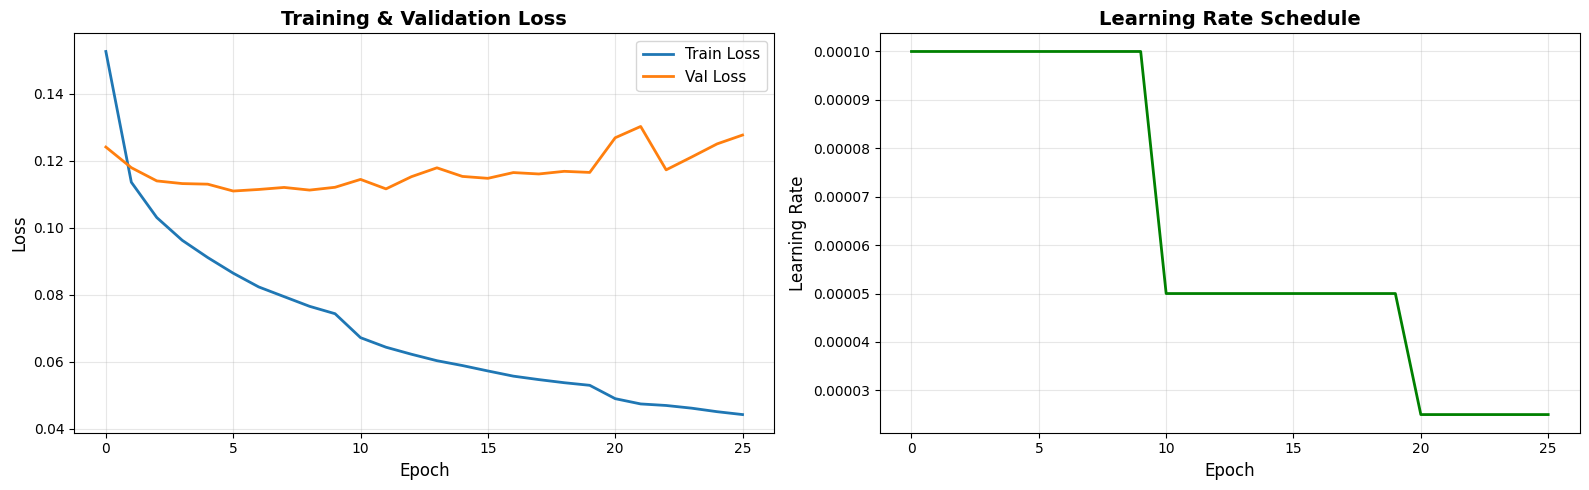

✓ Training history saved as training_history.png
✓ Training history saved as training_history.json


In [11]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Loss plot
axes[0].plot(history['train_loss'], label='Train Loss', linewidth=2)
axes[0].plot(history['val_loss'], label='Val Loss', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss', fontsize=12)
axes[0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
axes[0].legend(fontsize=11)
axes[0].grid(alpha=0.3)

# Learning rate plot
axes[1].plot(history['learning_rates'], color='green', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Learning Rate', fontsize=12)
axes[1].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

print('✓ Training history saved as training_history.png')

# Save history JSON
with open('training_history.json', 'w') as f:
    json.dump(history, f, indent=4)
print('✓ Training history saved as training_history.json')

In [12]:
print("\nLoading best model for evaluation...")
checkpoint = torch.load('best_efficientnet_triplet.pth')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
print(f"✓ Loaded model from epoch {checkpoint['epoch']+1}")
print(f"✓ Best validation loss: {checkpoint['val_loss']:.4f}")


Loading best model for evaluation...
✓ Loaded model from epoch 6
✓ Best validation loss: 0.1109


In [ ]:
metrics = evaluate_model(
    model=model, 
    dataset=val_dataset, 
    device=device,
    config=CONFIG,
    num_distance_samples=2000,
    num_embedding_samples=3000
)

print(f"Final Accuracy: {metrics['accuracy']:.4f}")
print(f"Final F1-Score: {metrics['f1_score']:.4f}")
print(f"Final ROC-AUC: {metrics['roc_auc']:.4f}")


STARTING COMPREHENSIVE EVALUATION

[1/5] Generating embeddings...
Generating embeddings for 3000 samples...


Generating embeddings: 100%|██████████| 3000/3000 [01:06<00:00, 45.13it/s]


✓ Generated embeddings shape: (9000, 224)
✓ Unique cats: 5447

[2/5] Computing distances...
Computing distances for 2000 samples...


Computing distances: 100%|██████████| 2000/2000 [00:43<00:00, 46.33it/s]


✓ Positive pairs: 2000
✓ Negative pairs: 2000

[3/5] Computing metrics...

VERIFICATION METRICS
Accuracy:  0.9370 (93.70%)
Precision: 0.9510
Recall:    0.9215
F1-Score:  0.9360
ROC-AUC:   0.9701
Optimal Threshold: 0.8067

[4/5] Generating visualizations...
✓ Confusion matrix saved as 'confusion_matrix.png'
✓ ROC curve saved as 'roc_curve.png'
✓ Distance distribution saved as 'distance_distribution.png'
Running t-SNE on 1000 samples...
✓ t-SNE completed!
✓ t-SNE plot (top 20) saved
✓ t-SNE plot (all cats) saved

[5/5] Generating summary report...

COMPREHENSIVE EVALUATION SUMMARY

Model: EfficientNet-B0 with Triplet Loss
Embedding Dimension: 224

VERIFICATION METRICS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Accuracy:   0.9370 (93.70%)
  • Precision:  0.9510
  • Recall:     0.9215
  • F1-Score:   0.9360
  • ROC-AUC:    0.9701

DISTANCE ANALYSIS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Optimal Threshold:       0.8067
  • Same Cat Mean Dist:      0.2887 ± 0.3208
  • Different Cat Mea

In [14]:
final_summary = f"""
{'='*70}
SUMMARY
{'='*70}

MODEL ARCHITECTURE:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Backbone: EfficientNet-B0
  • Embedding Dimension: {CONFIG['EMBEDDING_DIM']}
  • Total Parameters: {total_params:,}
  • Model Size: {total_params * 4 / 1024 / 1024:.2f} MB

TRAINING CONFIGURATION:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Loss: Triplet Margin Loss (margin={CONFIG['MARGIN']})
  • Optimizer: Adam (lr={CONFIG['LEARNING_RATE']})
  • Batch Size: {CONFIG['BATCH_SIZE']}
  • Epochs Trained: {len(history['train_loss'])}
  • Early Stopping Patience: {CONFIG['PATIENCE']}

DATASET:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Total Cats: {len(unique_cats):,}
  • Training Cats: {len(train_cat_ids):,}
  • Validation Cats: {len(val_cat_ids):,}
  • Training Images: {len(train_paths):,}
  • Validation Images: {len(val_paths):,}

TRAINING RESULTS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Best Train Loss: {min(history['train_loss']):.4f}
  • Best Val Loss: {best_val_loss:.4f}
  • Final Train Loss: {history['train_loss'][-1]:.4f}
  • Final Val Loss: {history['val_loss'][-1]:.4f}

EVALUATION METRICS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Accuracy: {metrics['accuracy']:.4f} ({metrics['accuracy']*100:.2f}%)
  • Precision: {metrics['precision']:.4f}
  • Recall: {metrics['recall']:.4f}
  • F1-Score: {metrics['f1_score']:.4f}
  • ROC-AUC: {metrics['roc_auc']:.4f}
  • Optimal Threshold: {metrics['optimal_threshold']:.4f}

DISTANCE ANALYSIS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Same Cat Mean: {metrics['pos_dist_mean']:.4f} ± {metrics['pos_dist_std']:.4f}
  • Different Cat Mean: {metrics['neg_dist_mean']:.4f} ± {metrics['neg_dist_std']:.4f}
  • Separation: {metrics['distance_separation']:.4f}

ALL GENERATED FILES:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  ✓ best_efficientnet_triplet.pth
  ✓ training_history.png
  ✓ training_history.json
  ✓ confusion_matrix.png
  ✓ roc_curve.png
  ✓ distance_distribution.png
  ✓ tsne_embeddings_top20.png
  ✓ tsne_embeddings_all.png
  ✓ evaluation_summary.txt
  ✓ final_summary.txt

{'='*70}
PROJECT COMPLETE! 🎉
{'='*70}
"""

print(final_summary)

# Save final summary
with open('final_summary.txt', 'w') as f:
    f.write(final_summary)

print("\nFinal summary saved as 'final_summary.txt'")


SUMMARY

MODEL ARCHITECTURE:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Backbone: EfficientNet-B0
  • Embedding Dimension: 224
  • Total Parameters: 4,779,804
  • Model Size: 18.23 MB

TRAINING CONFIGURATION:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Loss: Triplet Margin Loss (margin=1.0)
  • Optimizer: Adam (lr=0.0001)
  • Batch Size: 64
  • Epochs Trained: 26
  • Early Stopping Patience: 20

DATASET:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Total Cats: 164,100
  • Training Cats: 131,280
  • Validation Cats: 32,820
  • Training Images: 515,159
  • Validation Images: 128,380

TRAINING RESULTS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Best Train Loss: 0.0442
  • Best Val Loss: 0.1109
  • Final Train Loss: 0.0442
  • Final Val Loss: 0.1276

EVALUATION METRICS:
━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━
  • Accuracy: 0.9370 (93.70%)
  • Precision: 0.9510
  • Recall: 0.9215
  • F1-Score: 0.9360
  • ROC-AUC: 0.9701
  • Optimal Threshold: 0.8067

DISTANCE ANALYSIS:
━━━━━━━━━━━━━━━━━━━━━━━━